# Sentiment Analysis of Reddit

In order to examine how the interest regarding mental health management changed over time, before and during the COVID-19 pandemic, an analysis is carried out on two subreddits of Reddit:

- r\Meditation
- r\Mindfulness

The notebook consists of the following sections:

0. Preparation 
1. Querying Reddit
2. Sentiment Analysis
3. Plots
4. Statistical Analysis
5. Additional Comments Analysis

\* If data already collected, run sections 0, 2 (only the cell with nlp_preprocess() function definition), 3, and 4.2 to recreate all the plots. Make sure all the CSV files are stored in the same folder as the notebook.

## 0. Preparation 

Several packages are imported. Both PSAW and PRAW are used to query Reddit. Further, the sentiment analysis is conducted using the NLTK Vader analyzer. We further define two functions that help with saving and opening CSV files.

In [1]:
from psaw import PushshiftAPI
import praw

import pandas as pd
import datetime as dt
import numpy as np
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'plotly_white'
pio.renderers.default = 'jupyterlab'
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from scipy import stats

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudnikii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def save_data(df, year, comment = '', sentiment = ''):
    df.to_csv('reddit{}{}{}.csv'.format(year, comment, sentiment), sep=';', header=True, index=False)
    
        
def open_file(path):
    df = pd.read_csv(path, delimiter=';', header=0, lineterminator='\n')
    return df

## 1. Querying Reddit
In this section posts from November in 2019, 2020, and 2021 are collected and saved in individual csv. files. Here, PSAW is used as it allows querying posts from a specific timeframe. 

In [ ]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

def query_reddit(api, year):
    
    #set up the time frame
    start_epoch=int(dt.datetime(year, 10, 1).timestamp())
    end_epoch=int(dt.datetime(year, 10, 30).timestamp())
    
    query = {}
    
    query["meditation"] = list(api.search_submissions(subreddit='meditation', limit=1000,
                                               after = start_epoch, before=end_epoch))
    query["mindfulness"] = list(api.search_submissions(subreddit='mindfulness', limit=1000,
                                               after = start_epoch, before=end_epoch))
    
    data = { "title":[],
                "subreddit":[],
                "score":[], 
                "id":[], 
                "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}
    
    # save data in the dictionary
    for q in query.values():
        for submission in q:
            data["title"].append(submission.title)
            data['subreddit'].append(submission.subreddit)
            data["score"].append(submission.score)
            data["id"].append(submission.id)
            data["url"].append(submission.url)
            data["comms_num"].append(submission.num_comments)
            data["created"].append(submission.created)
            if hasattr(submission, 'selftext'):
                data["body"].append(submission.selftext)
            else:
                data["body"].append('[removed]')
     
    # create a pandas data frame
    df = pd.DataFrame(data)
    
    return df

def create_datasets(api):
    years = [2019, 2020, 2021]
    
    for year in years:
        print('starts creating the data set for year:', year)
        df = query_reddit(api, year)
        print('reddit query succeeded!')
        print('{} meditation posts downloaded'.format(len(df[df.subreddit == 'Meditation'])))
        print('{} mindfulness posts downloaded'.format(len(df[df.subreddit == 'Mindfulness'])))
        save_data(df, year)
        print('data saved as:', 'reddit{}.csv'.format(year))


In [ ]:
api = PushshiftAPI() #initialize PSAW API

In [ ]:
create_datasets(api) 

## 2. Sentiment Analysis

In this section we clean the datasets from deleted posts, preprocess all textual information for the sentiment analysis, and finally carry out the sentiment analysis on both titles and contents of the posts.

In [3]:
def clean_data(df, comment = False):
    
    # drop all the [removed] posts
    if not comment:
        df.drop(df.index[df['title'] == '[removed]'], inplace=True)
        df.drop(df.index[df['title'] == '[deleted]'], inplace=True)
    df.drop(df.index[df['body'] == '[removed]'], inplace=True)
    df.drop(df.index[df['body'] == '[deleted]'], inplace=True)
    
    # dropa all the empty posts
    if not comment:
        df = df[df['title'].notna()]
        df.drop(df.index[df['title'] == None], inplace=True)
    df = df[df['body'].notna()]
    df.drop(df.index[df['body'] == None], inplace=True)
    
    # drop the new lines
    df = df.replace(r'\n', ' ', regex = True)
    
    # time changes
    if not comment:
        # change time values to more readable
        df["created"] = df['created'].apply(get_date)
        # sort df by time
        df = df.sort_values(by='created')
        
    df = df.reset_index()
    
    return df


def nlp_preprocess(text, stopwords):
    # remove stop words
    text = ' '.join([x for x in text.split() if x not in stopwords.words()])
    
    # remove links
    text =  re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    
    # to lower case
    text = text.lower()

    return text


def sentiment_analysis(sid, df, stopwords, comment = False):
    title_scores = []
    body_scores = []
    
    df = clean_data(df, comment)
    
    for i in range(len(df)):
        if not comment:
            title = df['title'][i]
            title = nlp_preprocess(title, stopwords)
            title_scores.append(sid.polarity_scores(title)['compound'])
        
        body = df['body'][i]
        body = nlp_preprocess(body, stopwords)
        body_scores.append(sid.polarity_scores(body)['compound'])
        
    df['body_score'] = body_scores
    
    if not comment:
        df['title_score'] = title_scores
    
    return df

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
print('open file reddit2019.csv')
df19 = open_file('reddit2019.csv')
print('sentiment analysis...')
df19 = sentiment_analysis(sid, df19, stopwords)
print('open file reddit2020.csv')
df20 = open_file('reddit2020.csv')
print('sentiment analysis...')
df20 = sentiment_analysis(sid, df20, stopwords)
print('open file reddit2021.csv')
df21 = open_file('reddit2021.csv')
print('sentiment analysis...')
df21 = sentiment_analysis(sid, df21, stopwords)

In [ ]:
# save df with sentiment
save_data(df19, "2019", sentiment = 'S')
save_data(df20, "2020", sentiment = 'S')
save_data(df21, "2021", sentiment = 'S')

## 3. Plots

The code in this section allows for reproduction of all the plots presented in the report. 

In [4]:
df19 = open_file('reddit2019S.csv')
df20 = open_file('reddit2020S.csv')
df21 = open_file('reddit2021S.csv')

In [5]:
years = ['2019', '2020', '2021']

fig = go.Figure(data=[
    go.Bar(name='Mindfulness', x=years, y=[len(df19[df19.subreddit=='Mindfulness']),
                                            len(df20[df20.subreddit=='Mindfulness']),
                                            len(df21[df21.subreddit=='Mindfulness'])]),
    go.Bar(name='Meditation', x=years, y=[len(df19[df19.subreddit=='Meditation']), 
                                          len(df20[df20.subreddit=='Meditation']), 
                                          len(df21[df21.subreddit=='Meditation'])])
])
fig.update_layout(barmode='group')
fig.update_layout(title = "Overall Number of Posts Queried per Year")
fig.show()

In [6]:
print(len(df19), len(df20), len(df21))

952 952 834


The functions below transfrom the dataframes and allow for a more intuitive use of the plots. 

In [7]:
def get_scores(df, column):
    if column == 'body':
        return list(df["body_score"])
    elif column == 'title':
        return list(df["title_score"])
    else:
        print('no scores for this column')
        
def get_comp_scores(df19, df20, df21):
    
    # title
    years = ["2019"]*len(df19) + ["2020"]*len(df20) + ["2021"]*len(df21)
    scores = get_scores(df19, 'title') + get_scores(df20, 'title') + get_scores(df21, 'title')
    subreddits = list(df19.subreddit) + list(df20.subreddit) + list(df21.subreddit)

    title_scores = {
        'year' : years,
        'score' : scores,
        'subreddit' : subreddits 
    }
    
    title_scores = pd.DataFrame(title_scores)
    
    # body
    scores = get_scores(df19,'body') + get_scores(df20, 'body') + get_scores(df21, 'body')
    
    body_scores = {
        'year' : years,
        'score' : scores,
        'subreddit' : subreddits 
    }
    
    body_scores = pd.DataFrame(body_scores)
    return title_scores, body_scores

def get_comment_scores(df19, df20, df21):
    years = ["2019"]*len(df19) + ["2020"]*len(df20) + ["2021"]*len(df21)
    subreddits = list(df19.subreddit) + list(df20.subreddit) + list(df21.subreddit)
    comments = list(df19.comms_num) + list(df20.comms_num) + list(df21.comms_num)
    
    comm_scores = {
        'year' : years,
        'comments' : comments,
        'subreddit' : subreddits 
    }
    
    comm_scores = pd.DataFrame(comm_scores)
    return comm_scores

def get_score_scores(df19, df20, df21):
    pass

### 3.1. Compound Sentiment Scores
#### a) Title

In [8]:
title_scores, body_scores = get_comp_scores(df19, df20, df21)

In [9]:
fig = px.box(title_scores, x="year", y="score", color="subreddit")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout(title = "Boxplot of the Compound Sentiment Analysis Score of the Posts' Title per Year")
fig.show()

In [10]:
fig = go.Figure()

fig.add_trace(go.Box(x=title_scores.score[title_scores.year == '2019'], name = '2019'))
fig.add_trace(go.Box(x=title_scores.score[title_scores.year == '2020'], name = '2020'))
fig.add_trace(go.Box(x=title_scores.score[title_scores.year == '2021'], name = '2021'))

fig.update_layout(title = "Boxplot of the Compound Sentiment Analysis Score of the Posts' Title per Year")
fig.update_layout(xaxis_title='score',
                 yaxis_title='year')
fig.show()

#### b) Body

In [11]:
fig = px.box(body_scores, x="year", y="score", color="subreddit")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout(title = "Boxplot of the Compound Sentiment Analysis Score of the Posts' Content per Year")
fig.show()

In [12]:
fig = go.Figure()
fig.add_trace(go.Box(x=body_scores.score[title_scores.year == '2019'], name = '2019'))
fig.add_trace(go.Box(x=body_scores.score[title_scores.year == '2020'], name = '2020'))
fig.add_trace(go.Box(x=body_scores.score[title_scores.year == '2021'], name = '2021'))
fig.update_layout(title = "Boxplot of the Compound Sentiment Analysis Score of the Posts' Content per Year")
fig.update_layout(xaxis_title='score',
                 yaxis_title='year')
fig.show()

### 3.2. Number of Comments

In [13]:
years=['2019', '2020', '2021']

fig = go.Figure(data=[
    go.Bar(name='Mindfulness', x=years, y=[np.mean(df19.comms_num[df19.subreddit=='Mindfulness']),
                                            np.mean(df20.comms_num[df20.subreddit=='Mindfulness']),
                                            np.mean(df21.comms_num[df21.subreddit=='Mindfulness'])]),
    go.Bar(name='Meditation', x=years, y=[np.mean(df19.comms_num[df19.subreddit=='Meditation']),
                                            np.mean(df20.comms_num[df20.subreddit=='Meditation']),
                                            np.mean(df21.comms_num[df21.subreddit=='Meditation'])])
    
])
fig.update_layout(barmode='group')
fig.update_layout(title = 'Average Number of Comments per Post per Year')
fig.update_layout(legend_title='Subreddit',
                 yaxis_title='average number of comments')
fig.show()

In [14]:
fig = go.Figure(data=[
    go.Bar(name='Mindfulness', x=years, y=[sum(df19.comms_num[df19.subreddit=='Mindfulness']),
                                            sum(df20.comms_num[df20.subreddit=='Mindfulness']),
                                            sum(df21.comms_num[df21.subreddit=='Mindfulness'])]),
    go.Bar(name='Meditation', x=years, y=[sum(df19.comms_num[df19.subreddit=='Meditation']),
                                            sum(df20.comms_num[df20.subreddit=='Meditation']),
                                            sum(df21.comms_num[df21.subreddit=='Meditation'])]),
    
])
fig.update_layout(barmode='group')
fig.update_layout(title = 'Overall Number of Comments per Year')
fig.update_layout(legend_title='Subreddit',
                 yaxis_title='number of comments')
fig.show()

### 3.3. Reddit Scores

In [17]:
years=['2019', '2020', '2021']

fig = go.Figure(data=[
    go.Bar(name='Mindfulness', x=years, y=[np.mean(df19.score[df19.subreddit=='Mindfulness']),
                                            np.mean(df20.score[df20.subreddit=='Mindfulness']),
                                            np.mean(df21.score[df21.subreddit=='Mindfulness'])]),
    go.Bar(name='Meditation', x=years, y=[np.mean(df19.score[df19.subreddit=='Meditation']),
                                            np.mean(df20.score[df20.subreddit=='Meditation']),
                                            np.mean(df21.score[df21.subreddit=='Meditation'])])
])
fig.update_layout(barmode='group',legend_title='Subreddit')
fig.update_layout(title = 'Average Reddit Scores of the Posts per Year')
                  
fig.show()

### 3.4. Wordcloud

In [18]:
def get_wordclouds(df19, df20, df21):
    dfs = [df19, df20, df21]
    fig = plt.figure()
    i = 0
    year = 2019

    for df in dfs:
        
        # extract positive titles
        title_pos = df.title[[score > 0 for score in get_scores(df, 'title')]]
        title_pos = ' '.join([nlp_preprocess(text, stopwords) for text in title_pos])
        
        # remove words like meditation, meditating etc.
        remove_words = ['meditation', 'meditating', 'meditate', 'mindfulness']
        title_pos = ' '.join([word for word in title_pos.split() if word not in remove_words])

        # wordcloud
        wordcloud = WordCloud(max_words=20, background_color="white").generate(title_pos)
        
        # plot  
        ax = fig.add_subplot(3,2,i+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title('Positive Titles in {}'.format(year))
        i += 1
        
        # extract negative titles
        title_neg = df.title[[score < 0 for score in get_scores(df,  'title')]]
        title_neg = ' '.join([nlp_preprocess(text, stopwords) for text in title_neg])
        
        # remove words like meditation, meditating etc.
        title_neg = ' '.join([word for word in title_neg.split() if word not in remove_words])
        
        # wordcloud
        wordcloud = WordCloud(max_words=20, background_color="white").generate(title_neg)
        
        # plot                
        ax = fig.add_subplot(3,2,i+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title('Negative Titles in {}'.format(year))
        
        year += 1
        i += 1
    
    plt.tight_layout()
    plt.show()

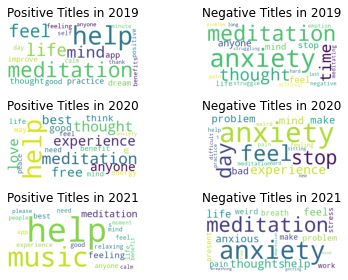

In [19]:
get_wordclouds(df19, df20, df21)

## 4. Statistical Analysis
In this section we first check if the assumptions for a parametric comparison test. Since the homogeneity of variance cannot be confirmed we carry out a non parametric test - Kruskal Wallis test. Results were not significant.

In [20]:
# check for normality of the data

# title_scores 
shapiro_test = stats.shapiro(df19.title_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df20.title_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df21.title_score)
print(shapiro_test.pvalue < 0.05)

# body_scores
shapiro_test = stats.shapiro(df19.body_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df20.body_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df21.body_score)
print(shapiro_test.pvalue < 0.05)


# check for variance homogenity

# title_scores 
stat, p = stats.bartlett(df19.title_score, df20.title_score, df21.title_score)
print(p < 0.05)

# body_scores
stat, p = stats.bartlett(df19.body_score, df20.body_score, df21.body_score)
print(p < 0.05)


True
True
True
True
True
True
False
False


In [21]:
print(stats.kruskal(df19.title_score, df20.title_score, df21.title_score))
print(stats.kruskal(df19.body_score, df20.body_score, df21.body_score))

KruskalResult(statistic=0.4164161615634535, pvalue=0.812038049618909)
KruskalResult(statistic=3.419681540637444, pvalue=0.18089459411260023)


## 5. Comments Analysis
### 5.1. Querying Reddit

In [ ]:
def get_comm_df(reddit, df):
    
    comments_data = {"id" : [],
                "parent_id" : [],
                "body" : [],
                "subreddit": []}
    
    df = df[df.comms_num > np.mean(df.comms_num)] #query only comments from popular posts
    df = df.reset_index()
    
    for i in range(len(df)):
        query = reddit.submission(id = df.id[i])
        for comment in query.comments.list():
                comments_data["id"].append(comment.id)
                comments_data["parent_id"].append(comment.parent_id)
                if hasattr(comment, 'body'):
                    comments_data["body"].append(comment.body)
                else:
                    comments_data["body"].append('[removed]')
                comments_data['subreddit'].append(df.subreddit[i])
                
    comm_df = pd.DataFrame(comments_data)
    return comm_df

def comm_analysis(reddit, sid, df19, df20, df21):
    years = ['2019', '2020', '2021']
    dfs = [df19, df20, df21]
    
    for i in range(3):
        print('year', years[i])
        print('querying the comments...')
        comm_df = get_comm_df(reddit, dfs[i])
        print('sentiment analysis...')
        comm_df = sentiment_analysis(sid, comm_df, stopwords, comment = True)
        save_data(comm_df, years[i], comment = 'C', sentiment = 'S')
        print('file saved as reddit{}CS'.format(years[i]))


In [ ]:
reddit = praw.Reddit(user_agent='sudnikii', client_id='SpsbOV_ltfZ6Eu3FQ4EHHg',
                      client_secret='VAKwQyNysAxg1Jx_eyYjWNY7XhOAcw',
                      redirect_url='https://www.reddit.com/prefs/apps/'
                                   'authorize_callback')

In [ ]:
comm_analysis(reddit, sid, df19, df20, df21)

### 5.2. Plots

In [22]:
print('open file reddit2019CS.csv')
df19_comm = open_file('reddit2019CS.csv')
print('open file reddit2020CS.csv')
df20_comm = open_file('reddit2020CS.csv')
print('open file reddit2021CS.csv')
df21_comm = open_file('reddit2021CS.csv')

open file reddit2019CS.csv
open file reddit2020CS.csv
open file reddit2021CS.csv


In [23]:
len(df19_comm) + len(df20_comm) + len(df21_comm)

18222

In [24]:
years=['2019', '2020', '2021']

fig = go.Figure(data=[
    go.Bar(name='Mindfulness', x=years, y=[len(df19_comm[df19_comm.subreddit=='Mindfulness']),
                                            len(df20_comm[df20_comm.subreddit=='Mindfulness']),
                                            len(df21_comm[df21_comm.subreddit=='Mindfulness'])]),
    go.Bar(name='Meditation', x=years, y=[len(df19_comm[df19_comm.subreddit=='Meditation']), 
                                          len(df20_comm[df20_comm.subreddit=='Meditation']), 
                                          len(df21_comm[df21_comm.subreddit=='Meditation'])])
])
fig.update_layout(barmode='group')
fig.update_layout(title='Overall Number of Comments Queried per Year')
fig.show()

In [25]:
years = ["2019"]*len(df19_comm) + ["2020"]*len(df20_comm) + ["2021"]*len(df21_comm)
scores = get_scores(df19_comm,'body') + get_scores(df20_comm, 'body') + get_scores(df21_comm, 'body')
subreddits = list(df19_comm.subreddit) + list(df20_comm.subreddit) + list(df21_comm.subreddit)


body_scores_comm = {
    'year' : years,
    'score' : scores,
    'subreddit' : subreddits 
}

body_scores_comm = pd.DataFrame(body_scores)

In [26]:
fig = px.box(body_scores_comm, x="year", y="score", color="subreddit")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout(title = 'Boxplot of Compound Sentiment Analysis Score per Year')
fig.show()

In [27]:
fig = go.Figure()
fig.add_trace(go.Box(x=body_scores_comm.score[body_scores_comm.year == '2019'], name = '2019'))
fig.add_trace(go.Box(x=body_scores_comm.score[body_scores_comm.year == '2020'], name = '2020'))
fig.add_trace(go.Box(x=body_scores_comm.score[body_scores_comm.year == '2021'], name = '2021'))
fig.update_layout(title = 'Boxplot of Compound Sentiment Analysis Score per Year')
fig.show()

### 5.3. Statistical Analysis

In [28]:
# check for normality of the data

shapiro_test = stats.shapiro(df19_comm.body_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df20_comm.body_score)
print(shapiro_test.pvalue < 0.05)
shapiro_test = stats.shapiro(df21_comm.body_score)
print(shapiro_test.pvalue < 0.05)


# check for variance homogenity
stat, p = stats.bartlett(df19_comm.body_score, df20_comm.body_score, df21_comm.body_score)
print(p < 0.05)

True
True
True
False


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



In [29]:
print(stats.kruskal(df19_comm.body_score, df20_comm.body_score, df21_comm.body_score))

KruskalResult(statistic=60.59689168098062, pvalue=6.943079870337406e-14)


In [30]:
stats.mannwhitneyu(x=df19_comm.body_score, y=df20_comm.body_score)

MannwhitneyuResult(statistic=13907649.5, pvalue=0.0001396529299892549)

In [31]:
stats.mannwhitneyu(x=df19_comm.body_score, y=df21_comm.body_score)

MannwhitneyuResult(statistic=20183157.0, pvalue=5.577188453989995e-05)

In [32]:
stats.mannwhitneyu(x=df20_comm.body_score, y=df21_comm.body_score)

MannwhitneyuResult(statistic=17543901.5, pvalue=2.909676911827445e-15)